### Deep Neural Network for SOC Prediction with using LG 18650HG2 Li-ion Battery and Panasonic 18650PF

In [115]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [133]:
PROCESSED_DATA_DIR = '../../datasets/combined_dataset'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 1024
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [117]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [118]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [119]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [120]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [121]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [122]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-08 09:53:14,0.000000,0.000000,4.18936,-0.05108,23.345190,0.00000,0.000000,0.000000,1.005569,0.0,562_Mixed6_processed.csv,-0.213993
1,2018-11-08 09:53:14,0.010033,0.602000,4.18784,-0.09450,23.345190,-0.00001,0.000029,-0.000015,0.999995,1.0,562_Mixed6_processed.csv,-0.395751
2,2018-11-08 09:53:15,0.025017,1.501000,4.18767,-0.09450,23.345190,-0.00004,0.000028,-0.000039,0.999987,2.0,562_Mixed6_processed.csv,-0.395735
3,2018-11-08 09:53:16,0.041700,2.502000,4.18750,-0.09450,23.345190,-0.00006,0.000028,-0.000065,0.999977,3.0,562_Mixed6_processed.csv,-0.395719
4,2018-11-08 09:53:17,0.059983,3.599000,4.18734,-0.09195,23.345190,-0.00009,0.000028,-0.000093,0.999966,4.0,562_Mixed6_processed.csv,-0.385026
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240964,2017-06-11 23:47:32,NaN,12279.470994,3.44601,0.00000,-6.768772,-2.03006,0.000027,-2.030721,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
4240965,2017-06-11 23:47:33,NaN,12279.570993,3.44601,0.00000,-6.768772,-2.03006,0.000028,-2.030721,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
4240966,2017-06-11 23:47:33,NaN,12279.669997,3.44601,0.00000,-6.768772,-2.03006,0.000028,-2.030721,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
4240967,2017-06-11 23:47:33,NaN,12279.771998,3.44601,0.00000,-6.768772,-2.03006,0.000028,-2.030721,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000


In [123]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [min],Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Time_diff,Cumulative_Capacity_Ah,SOC [-],Rounded_Time,SourceFile,Power [W]
0,2018-11-08 09:53:14,0.000000,0.000000,2.037330,0.496984,0.961276,0.00000,0.000000,1.662841,1.005569,0.0,562_Mixed6_processed.csv,0.487373
1,2018-11-08 09:53:14,0.010033,0.602000,2.032003,0.474156,0.961276,-0.00001,0.000029,1.662820,0.999995,1.0,562_Mixed6_processed.csv,0.459376
2,2018-11-08 09:53:15,0.025017,1.501000,2.031407,0.474156,0.961276,-0.00004,0.000028,1.662787,0.999987,2.0,562_Mixed6_processed.csv,0.459379
3,2018-11-08 09:53:16,0.041700,2.502000,2.030811,0.474156,0.961276,-0.00006,0.000028,1.662751,0.999977,3.0,562_Mixed6_processed.csv,0.459381
4,2018-11-08 09:53:17,0.059983,3.599000,2.030251,0.475497,0.961276,-0.00009,0.000028,1.662711,0.999966,4.0,562_Mixed6_processed.csv,0.461028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240964,2017-06-11 23:47:32,NaN,12279.470994,-0.567939,0.523839,-1.062728,-2.03006,0.000027,-1.168031,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.520335
4240965,2017-06-11 23:47:33,NaN,12279.570993,-0.567939,0.523839,-1.062728,-2.03006,0.000028,-1.168031,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.520335
4240966,2017-06-11 23:47:33,NaN,12279.669997,-0.567939,0.523839,-1.062728,-2.03006,0.000028,-1.168031,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.520335
4240967,2017-06-11 23:47:33,NaN,12279.771998,-0.567939,0.523839,-1.062728,-2.03006,0.000028,-1.168031,0.000008,NaN,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.520335


In [124]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [125]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [126]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [127]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [134]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [129]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'567_Mixed2_processed.csv', '601_US06_processed.csv', '552_Mixed4_processed.csv', '06-10-17_11.25 n10degC_Cycle_1_Pan18650PF_processed.csv', '04-05-17_22.50 10degC_Cycle_4_Pan18650PF_processed.csv', '590_Mixed5_processed.csv', '589_Mixed1_processed.csv', '549_HPPC_processed.csv', '602_Mixed5_processed.csv', '06-11-17_08.42 n10degC_Cycle_4_Pan18650PF_processed.csv', '06-24-17_04.29 n20degC_Cycle_1_Pan18650PF_processed.csv', '562_Mixed4_processed.csv', '05-30-17_12.56 0degC_Cycle_1_Pan18650PF_processed.csv', '596_UDDS_processed.csv', '06-11-17_01.39 n10degC_Cycle_3_Pan18650PF_processed.csv', '601_Mixed1_processed.csv', '06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv', '590_Mixed4_processed.csv', '03-21-17_09.38 25degC_LA92_Pan18650PF_processed.csv', '589_Mixed2_processed.csv', '575_HPPC_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '06-02-17_04.58 0degC_US06_Pan18650PF_processed.csv', '03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv', '06-

In [130]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([3145294, 5])
Test features shape: torch.Size([692077, 5])
Train labels shape: torch.Size([3145294])
Test labels shape: torch.Size([692077])


## Hyperparameter tuning

In [135]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256, 512])
    num_layers = trial.suggest_int('num_layers', 1, 6)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [136]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-08-05 00:49:31,050] A new study created in memory with name: no-name-9dcaea09-785f-4b50-8339-4d4f99d14a52
Epoch: 0/10: 100%|██████████| 3072/3072 [00:20<00:00, 152.76it/s]


Epoch 1/10, Train Loss: 0.006286467559145119, Validation Loss: 0.02031318064332539
Time taken for epoch: 20.11141086 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:20<00:00, 147.37it/s]


Epoch 2/10, Train Loss: 0.00613851570915358, Validation Loss: 0.0059485804359230565
Time taken for epoch: 20.84772778 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:21<00:00, 143.31it/s]


Epoch 3/10, Train Loss: 0.006366965028670772, Validation Loss: 0.00817677023806948
Time taken for epoch: 21.43832827 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:23<00:00, 130.60it/s]


Epoch 4/10, Train Loss: 0.006689173805474032, Validation Loss: 0.01388363976471148
Time taken for epoch: 23.52394009 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:27<00:00, 110.40it/s]


Epoch 5/10, Train Loss: 0.006699632833563858, Validation Loss: 0.0027457442624617663
Time taken for epoch: 27.82923412 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:27<00:00, 111.20it/s]


Epoch 6/10, Train Loss: 0.0067552025910420825, Validation Loss: 0.015606570642714498
Time taken for epoch: 27.62867522 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:26<00:00, 117.50it/s]


Epoch 7/10, Train Loss: 0.007041078333713813, Validation Loss: 0.00394189780077231
Time taken for epoch: 26.14642215 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:25<00:00, 121.11it/s]


Epoch 8/10, Train Loss: 0.006964104580977922, Validation Loss: 0.007475021453595368
Time taken for epoch: 25.36650300 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:25<00:00, 122.77it/s]


Epoch 9/10, Train Loss: 0.006899159029823447, Validation Loss: 0.004006557213483287
Time taken for epoch: 25.02539611 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:25<00:00, 121.81it/s]
[I 2025-08-05 00:53:58,342] Trial 0 finished with value: 0.005539555216740995 and parameters: {'learning_rate': 0.04031746494604795, 'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.2973374528917341}. Best is trial 0 with value: 0.005539555216740995.


Epoch 10/10, Train Loss: 0.007089268036907015, Validation Loss: 0.005539555216740995
Time taken for epoch: 25.22258711 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:25<00:00, 119.59it/s]


Epoch 1/10, Train Loss: 0.03376307238977461, Validation Loss: 0.008696810404611266
Time taken for epoch: 25.69012809 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:25<00:00, 118.67it/s]


Epoch 2/10, Train Loss: 0.024697954092819902, Validation Loss: 0.009320420662146417
Time taken for epoch: 25.88884306 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:25<00:00, 118.52it/s]


Epoch 3/10, Train Loss: 0.024703738342092645, Validation Loss: 0.008440501725190303
Time taken for epoch: 25.92271709 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:25<00:00, 119.28it/s]


Epoch 4/10, Train Loss: 0.024750487442967522, Validation Loss: 0.00839371198006212
Time taken for epoch: 25.75603104 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:25<00:00, 120.60it/s]


Epoch 5/10, Train Loss: 0.024740988889485987, Validation Loss: 0.0074953900570361364
Time taken for epoch: 25.47460794 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:25<00:00, 119.92it/s]


Epoch 6/10, Train Loss: 0.02475432790015475, Validation Loss: 0.008214907358980113
Time taken for epoch: 25.61813688 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:25<00:00, 120.02it/s]


Epoch 7/10, Train Loss: 0.02473413489193869, Validation Loss: 0.00843795624005918
Time taken for epoch: 25.59695983 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:26<00:00, 117.47it/s]


Epoch 8/10, Train Loss: 0.024692293562111445, Validation Loss: 0.008217248366839998
Time taken for epoch: 26.15272689 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:27<00:00, 112.77it/s]


Epoch 9/10, Train Loss: 0.024724457434179687, Validation Loss: 0.008151145898045798
Time taken for epoch: 27.24284101 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:30<00:00, 100.56it/s]
[I 2025-08-05 00:58:47,482] Trial 1 finished with value: 0.008038257785995748 and parameters: {'learning_rate': 0.0008908485719506504, 'hidden_size': 16, 'num_layers': 2, 'dropout_rate': 0.4963202824578564}. Best is trial 0 with value: 0.005539555216740995.


Epoch 10/10, Train Loss: 0.0247229818408717, Validation Loss: 0.008038257785995748
Time taken for epoch: 30.55239987 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:35<00:00, 87.31it/s] 


Epoch 1/10, Train Loss: 0.5000508250571633, Validation Loss: 0.10974962182130805
Time taken for epoch: 35.18543410 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.97it/s]


Epoch 2/10, Train Loss: 0.13966222204423198, Validation Loss: 0.04181463105248175
Time taken for epoch: 30.12784410 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:28<00:00, 109.36it/s]


Epoch 3/10, Train Loss: 0.06629703789076302, Validation Loss: 0.02362839659862736
Time taken for epoch: 28.09408617 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:27<00:00, 109.96it/s]


Epoch 4/10, Train Loss: 0.045534284957587566, Validation Loss: 0.018487245994618182
Time taken for epoch: 27.93861580 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:27<00:00, 110.10it/s]


Epoch 5/10, Train Loss: 0.040269167664519046, Validation Loss: 0.01955083471963652
Time taken for epoch: 27.90348482 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:28<00:00, 106.89it/s]


Epoch 6/10, Train Loss: 0.040045590662581766, Validation Loss: 0.01928644965270525
Time taken for epoch: 28.74152613 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:28<00:00, 108.50it/s]


Epoch 7/10, Train Loss: 0.0401014391342566, Validation Loss: 0.019424433895205134
Time taken for epoch: 28.31688929 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:28<00:00, 108.46it/s]


Epoch 8/10, Train Loss: 0.0400905601697256, Validation Loss: 0.018886599610275973
Time taken for epoch: 28.32677603 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:28<00:00, 109.45it/s]


Epoch 9/10, Train Loss: 0.040058499054187756, Validation Loss: 0.019392152224813625
Time taken for epoch: 28.06870604 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:27<00:00, 109.92it/s]
[I 2025-08-05 01:04:06,062] Trial 2 finished with value: 0.019354442672027038 and parameters: {'learning_rate': 6.681409793624082e-05, 'hidden_size': 16, 'num_layers': 2, 'dropout_rate': 0.6757676076679916}. Best is trial 0 with value: 0.005539555216740995.


Epoch 10/10, Train Loss: 0.04009598172827585, Validation Loss: 0.019354442672027038
Time taken for epoch: 27.94973898 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.16it/s]


Epoch 1/10, Train Loss: 0.07563271241087932, Validation Loss: 0.012939179089086412
Time taken for epoch: 30.36994290 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.25it/s]


Epoch 2/10, Train Loss: 0.030165108191188967, Validation Loss: 0.010889949920430976
Time taken for epoch: 30.34402704 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:30<00:00, 102.34it/s]


Epoch 3/10, Train Loss: 0.02969964419086561, Validation Loss: 0.010778125314330561
Time taken for epoch: 30.02106476 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:30<00:00, 100.88it/s]


Epoch 4/10, Train Loss: 0.02970131308939017, Validation Loss: 0.011491426876558405
Time taken for epoch: 30.45566201 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:30<00:00, 102.12it/s]


Epoch 5/10, Train Loss: 0.02970440437760165, Validation Loss: 0.011503351640274996
Time taken for epoch: 30.08349609 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.85it/s]


Epoch 6/10, Train Loss: 0.029716044542510645, Validation Loss: 0.011282677046811046
Time taken for epoch: 30.16354108 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.96it/s]


Epoch 7/10, Train Loss: 0.029720270740047756, Validation Loss: 0.01143572591697792
Time taken for epoch: 30.13260388 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.38it/s]


Epoch 8/10, Train Loss: 0.029705685570055113, Validation Loss: 0.011617450069757127
Time taken for epoch: 30.30321097 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:32<00:00, 94.89it/s] 


Epoch 9/10, Train Loss: 0.029721303825378225, Validation Loss: 0.012106439767894354
Time taken for epoch: 32.37577820 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:34<00:00, 88.69it/s] 
[I 2025-08-05 01:09:42,993] Trial 3 finished with value: 0.010950628237186939 and parameters: {'learning_rate': 0.0005766552501597825, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.5488197632593979}. Best is trial 0 with value: 0.005539555216740995.


Epoch 10/10, Train Loss: 0.029726639934475923, Validation Loss: 0.010950628237186939
Time taken for epoch: 34.64053082 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [01:46<00:00, 28.82it/s]


Epoch 1/10, Train Loss: 0.02040217975415241, Validation Loss: 0.004041068536282651
Time taken for epoch: 106.58649707 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [01:44<00:00, 29.29it/s]


Epoch 2/10, Train Loss: 0.017770719445252325, Validation Loss: 0.0044187565088186255
Time taken for epoch: 104.88243008 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [01:44<00:00, 29.33it/s]


Epoch 3/10, Train Loss: 0.017787611909322248, Validation Loss: 0.004156269510066165
Time taken for epoch: 104.72450089 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [01:45<00:00, 29.25it/s]


Epoch 4/10, Train Loss: 0.01787828276428627, Validation Loss: 0.005611265588229315
Time taken for epoch: 105.03228307 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [01:44<00:00, 29.40it/s]


Epoch 5/10, Train Loss: 0.01792471973900926, Validation Loss: 0.0042044580883433625
Time taken for epoch: 104.49604106 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [01:44<00:00, 29.29it/s]


Epoch 6/10, Train Loss: 0.01800311535437989, Validation Loss: 0.005960353516980785
Time taken for epoch: 104.89467287 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3072/3072 [01:44<00:00, 29.47it/s]


Epoch 7/10, Train Loss: 0.018010909779756428, Validation Loss: 0.004954944131692127
Time taken for epoch: 104.25025105 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3072/3072 [01:45<00:00, 29.21it/s]


Epoch 8/10, Train Loss: 0.018033830780344335, Validation Loss: 0.0060038770863028255
Time taken for epoch: 105.18295288 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [01:43<00:00, 29.54it/s]


Epoch 9/10, Train Loss: 0.017997066790485405, Validation Loss: 0.0060844112822992374
Time taken for epoch: 103.98211789 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [01:43<00:00, 29.65it/s]
[I 2025-08-05 01:28:04,559] Trial 4 finished with value: 0.005204324734812054 and parameters: {'learning_rate': 0.0024847576659732117, 'hidden_size': 512, 'num_layers': 6, 'dropout_rate': 0.4764867591468077}. Best is trial 4 with value: 0.005204324734812054.


Epoch 10/10, Train Loss: 0.01799132450196339, Validation Loss: 0.005204324734812054
Time taken for epoch: 103.60165882 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:36<00:00, 83.64it/s] 


Epoch 1/10, Train Loss: 0.2219909933191957, Validation Loss: 0.03340805268881819
Time taken for epoch: 36.73087788 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:34<00:00, 89.66it/s] 


Epoch 2/10, Train Loss: 0.05129957415556419, Validation Loss: 0.017070576847525824
Time taken for epoch: 34.26691508 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:34<00:00, 88.93it/s] 


Epoch 3/10, Train Loss: 0.020024118053091417, Validation Loss: 0.00826954780790448
Time taken for epoch: 34.54516673 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.30it/s] 


Epoch 4/10, Train Loss: 0.012787591092395209, Validation Loss: 0.004062032413589171
Time taken for epoch: 33.64945102 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.06it/s] 


Epoch 5/10, Train Loss: 0.010184670798783676, Validation Loss: 0.0031888178569784895
Time taken for epoch: 33.73672199 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:33<00:00, 92.57it/s] 


Epoch 6/10, Train Loss: 0.008958675805388339, Validation Loss: 0.0025814586183088655
Time taken for epoch: 33.18644500 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.99it/s] 


Epoch 7/10, Train Loss: 0.008209626766377673, Validation Loss: 0.0026208706341773755
Time taken for epoch: 33.39584208 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.31it/s] 


Epoch 8/10, Train Loss: 0.007823688714627982, Validation Loss: 0.0025865179378262286
Time taken for epoch: 33.64683700 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.14it/s] 


Epoch 9/10, Train Loss: 0.007688038461765245, Validation Loss: 0.0024360831414958714
Time taken for epoch: 33.70730901 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:33<00:00, 91.52it/s] 
[I 2025-08-05 01:34:13,195] Trial 5 finished with value: 0.0027085710690272794 and parameters: {'learning_rate': 2.1074781122288086e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.5762464831672783}. Best is trial 5 with value: 0.0027085710690272794.


Epoch 10/10, Train Loss: 0.007636175493644259, Validation Loss: 0.0027085710690272794
Time taken for epoch: 33.57006812 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:34<00:00, 88.52it/s] 


Epoch 1/10, Train Loss: 1.596839859286168, Validation Loss: 0.9159100145478792
Time taken for epoch: 34.70416307 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:34<00:00, 88.31it/s] 


Epoch 2/10, Train Loss: 0.7995703229486631, Validation Loss: 0.6322300796455975
Time taken for epoch: 34.78852582 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:35<00:00, 87.16it/s] 


Epoch 3/10, Train Loss: 0.5251617938532339, Validation Loss: 0.41021252048755935
Time taken for epoch: 35.24566817 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:37<00:00, 81.21it/s] 


Epoch 4/10, Train Loss: 0.33030774336172425, Validation Loss: 0.2492289702975195
Time taken for epoch: 37.83175969 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:40<00:00, 76.69it/s]


Epoch 5/10, Train Loss: 0.19664230514414763, Validation Loss: 0.14546477955849446
Time taken for epoch: 40.05691910 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:40<00:00, 76.26it/s]


Epoch 6/10, Train Loss: 0.11675154252831514, Validation Loss: 0.08839065405486105
Time taken for epoch: 40.28607917 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:40<00:00, 76.46it/s]


Epoch 7/10, Train Loss: 0.08173696005784829, Validation Loss: 0.06672304099450495
Time taken for epoch: 40.18132806 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:40<00:00, 76.29it/s]


Epoch 8/10, Train Loss: 0.07324691075094354, Validation Loss: 0.05691795246203134
Time taken for epoch: 40.27223396 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:40<00:00, 76.22it/s]


Epoch 9/10, Train Loss: 0.07219810408908718, Validation Loss: 0.05663149093802358
Time taken for epoch: 40.30720711 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:39<00:00, 77.75it/s]
[I 2025-08-05 01:41:07,002] Trial 6 finished with value: 0.056700065662876054 and parameters: {'learning_rate': 6.035532179140785e-05, 'hidden_size': 32, 'num_layers': 5, 'dropout_rate': 0.581646508147802}. Best is trial 5 with value: 0.0027085710690272794.


Epoch 10/10, Train Loss: 0.07218802676410026, Validation Loss: 0.056700065662876054
Time taken for epoch: 39.51294899 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:42<00:00, 72.66it/s]


Epoch 1/10, Train Loss: 0.2236895009300497, Validation Loss: 0.014412332671551517
Time taken for epoch: 42.27953506 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:41<00:00, 73.65it/s]


Epoch 2/10, Train Loss: 0.04256968346877935, Validation Loss: 0.007039641415494886
Time taken for epoch: 41.71254802 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:42<00:00, 71.90it/s]


Epoch 3/10, Train Loss: 0.021733170897277887, Validation Loss: 0.008433410128368969
Time taken for epoch: 42.73079300 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:44<00:00, 69.42it/s]


Epoch 4/10, Train Loss: 0.020178718107369303, Validation Loss: 0.008187957067938545
Time taken for epoch: 44.25181580 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:42<00:00, 72.01it/s]


Epoch 5/10, Train Loss: 0.020182074499947095, Validation Loss: 0.00750094874902176
Time taken for epoch: 42.66062474 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:41<00:00, 73.72it/s]


Epoch 6/10, Train Loss: 0.020192278608495446, Validation Loss: 0.008592089863129872
Time taken for epoch: 41.67527390 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:41<00:00, 74.21it/s]


Epoch 7/10, Train Loss: 0.020189680050558916, Validation Loss: 0.007760249060150652
Time taken for epoch: 41.39865589 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3072/3072 [00:42<00:00, 73.06it/s]


Epoch 8/10, Train Loss: 0.02012932045060249, Validation Loss: 0.007666887196897227
Time taken for epoch: 42.05027699 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:42<00:00, 72.96it/s]


Epoch 9/10, Train Loss: 0.02017476796269572, Validation Loss: 0.007395210676339888
Time taken for epoch: 42.10579205 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:42<00:00, 72.78it/s]
[I 2025-08-05 01:48:42,544] Trial 7 finished with value: 0.007573204739165254 and parameters: {'learning_rate': 0.00023296777472983445, 'hidden_size': 64, 'num_layers': 5, 'dropout_rate': 0.25412594058668414}. Best is trial 5 with value: 0.0027085710690272794.


Epoch 10/10, Train Loss: 0.020150565088139654, Validation Loss: 0.007573204739165254
Time taken for epoch: 42.21378398 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [01:43<00:00, 29.60it/s]


Epoch 1/10, Train Loss: 0.2867161240137648, Validation Loss: 0.03363732472174474
Time taken for epoch: 103.77494502 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [01:42<00:00, 29.99it/s]


Epoch 2/10, Train Loss: 0.04983478875025563, Validation Loss: 0.012169988058137935
Time taken for epoch: 102.44575191 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [01:53<00:00, 27.12it/s]


Epoch 3/10, Train Loss: 0.02009516606449324, Validation Loss: 0.003637636132761939
Time taken for epoch: 113.29032922 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [01:53<00:00, 27.13it/s]


Epoch 4/10, Train Loss: 0.012374530010371624, Validation Loss: 0.0030482849926902187
Time taken for epoch: 113.22804308 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [01:53<00:00, 27.10it/s]


Epoch 5/10, Train Loss: 0.010511336198760546, Validation Loss: 0.0024920134150582997
Time taken for epoch: 113.36823487 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [01:41<00:00, 30.33it/s]


Epoch 6/10, Train Loss: 0.0096368481696724, Validation Loss: 0.0024341803306590836
Time taken for epoch: 101.28086472 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [01:40<00:00, 30.63it/s]


Epoch 7/10, Train Loss: 0.009309051098322621, Validation Loss: 0.0025519196792111306
Time taken for epoch: 100.30265403 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [01:40<00:00, 30.49it/s]


Epoch 8/10, Train Loss: 0.00920405112537992, Validation Loss: 0.002630600731770502
Time taken for epoch: 100.76919723 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [01:40<00:00, 30.68it/s]


Epoch 9/10, Train Loss: 0.009179110843433591, Validation Loss: 0.0027741213504035656
Time taken for epoch: 100.12729216 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [01:40<00:00, 30.68it/s]
[I 2025-08-05 02:07:05,678] Trial 8 finished with value: 0.0026440295208523153 and parameters: {'learning_rate': 2.8414930018172316e-05, 'hidden_size': 512, 'num_layers': 4, 'dropout_rate': 0.6703749270352437}. Best is trial 8 with value: 0.0026440295208523153.


Epoch 10/10, Train Loss: 0.00918426241802687, Validation Loss: 0.0026440295208523153
Time taken for epoch: 100.11852193 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:33<00:00, 90.79it/s] 


Epoch 1/10, Train Loss: 0.043600636930326196, Validation Loss: 0.004502019153103534
Time taken for epoch: 33.83838797 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:34<00:00, 89.57it/s] 


Epoch 2/10, Train Loss: 0.015065268710410843, Validation Loss: 0.004148920366141502
Time taken for epoch: 34.29979181 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:35<00:00, 86.61it/s] 


Epoch 3/10, Train Loss: 0.014670706666038313, Validation Loss: 0.004246901056021785
Time taken for epoch: 35.46956110 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:35<00:00, 86.71it/s] 


Epoch 4/10, Train Loss: 0.014654298772560045, Validation Loss: 0.0038398555457036486
Time taken for epoch: 35.43167996 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:35<00:00, 86.57it/s] 


Epoch 5/10, Train Loss: 0.014660894593059007, Validation Loss: 0.004451846077336086
Time taken for epoch: 35.48908305 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:34<00:00, 90.02it/s] 


Epoch 6/10, Train Loss: 0.014668947127878104, Validation Loss: 0.004370560425311713
Time taken for epoch: 34.12906694 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:34<00:00, 89.03it/s] 


Epoch 7/10, Train Loss: 0.014645937879322446, Validation Loss: 0.004144408054674651
Time taken for epoch: 34.50683594 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:32<00:00, 95.85it/s] 


Epoch 8/10, Train Loss: 0.014669852946705456, Validation Loss: 0.004006783168439672
Time taken for epoch: 32.05233788 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:31<00:00, 98.49it/s] 


Epoch 9/10, Train Loss: 0.014656614042602692, Validation Loss: 0.00398371972588203
Time taken for epoch: 31.19211292 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:30<00:00, 101.39it/s]
[I 2025-08-05 02:13:11,686] Trial 9 finished with value: 0.004358785025938175 and parameters: {'learning_rate': 0.000296498394296975, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.31149545768407694}. Best is trial 8 with value: 0.0026440295208523153.


Epoch 10/10, Train Loss: 0.014652798101148315, Validation Loss: 0.004358785025938175
Time taken for epoch: 30.30012918 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [01:16<00:00, 40.14it/s]


Epoch 1/10, Train Loss: 0.005497752332000043, Validation Loss: 0.007589037370624144
Time taken for epoch: 76.53926826 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [01:14<00:00, 41.04it/s]


Epoch 2/10, Train Loss: 0.00489480974010803, Validation Loss: 0.002941935137116875
Time taken for epoch: 74.86050510 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [01:14<00:00, 41.21it/s]


Epoch 3/10, Train Loss: 0.004941669973428968, Validation Loss: 0.006478632994300444
Time taken for epoch: 74.54638481 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [01:17<00:00, 39.88it/s]


Epoch 4/10, Train Loss: 0.005053278692685126, Validation Loss: 0.02711283821208781
Time taken for epoch: 77.03290391 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [01:18<00:00, 39.02it/s]


Epoch 5/10, Train Loss: 0.005011780835275204, Validation Loss: 0.004508195319587823
Time taken for epoch: 78.72704220 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [01:37<00:00, 31.35it/s]


Epoch 6/10, Train Loss: 0.005021559885184009, Validation Loss: 0.017099973955458765
Time taken for epoch: 97.99346995 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [01:37<00:00, 31.39it/s]


Epoch 7/10, Train Loss: 0.005049515524357655, Validation Loss: 0.006273710252603854
Time taken for epoch: 97.86366320 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3072/3072 [01:37<00:00, 31.38it/s]


Epoch 8/10, Train Loss: 0.005044638733579632, Validation Loss: 0.006081400182974212
Time taken for epoch: 97.91369319 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [01:37<00:00, 31.36it/s]


Epoch 9/10, Train Loss: 0.0051006852067985164, Validation Loss: 0.0032334589230766696
Time taken for epoch: 97.94924712 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [01:37<00:00, 31.52it/s]
[I 2025-08-05 02:28:31,936] Trial 10 finished with value: 0.0038847770232378833 and parameters: {'learning_rate': 0.00794089632764656, 'hidden_size': 512, 'num_layers': 4, 'dropout_rate': 0.13775827595504797}. Best is trial 8 with value: 0.0026440295208523153.


Epoch 10/10, Train Loss: 0.005068954112251352, Validation Loss: 0.0038847770232378833
Time taken for epoch: 97.45774174 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:30<00:00, 99.41it/s] 


Epoch 1/10, Train Loss: 0.3436026297713397, Validation Loss: 0.023320131616879115
Time taken for epoch: 30.90313292 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:31<00:00, 96.63it/s] 


Epoch 2/10, Train Loss: 0.10831573464141304, Validation Loss: 0.017659523522842724
Time taken for epoch: 31.79291201 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:32<00:00, 94.31it/s] 


Epoch 3/10, Train Loss: 0.038329279066601885, Validation Loss: 0.013664401832675485
Time taken for epoch: 32.57709408 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:32<00:00, 95.65it/s] 


Epoch 4/10, Train Loss: 0.024205530095059657, Validation Loss: 0.01031015284779987
Time taken for epoch: 32.12010598 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:32<00:00, 95.10it/s] 


Epoch 5/10, Train Loss: 0.019842763381044886, Validation Loss: 0.007997858187961436
Time taken for epoch: 32.30447912 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:31<00:00, 97.31it/s] 


Epoch 6/10, Train Loss: 0.016641265618090983, Validation Loss: 0.006502796986005475
Time taken for epoch: 31.57269406 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:31<00:00, 96.55it/s] 


Epoch 7/10, Train Loss: 0.013901522254855081, Validation Loss: 0.004964265138698488
Time taken for epoch: 31.82052922 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:31<00:00, 96.38it/s] 


Epoch 8/10, Train Loss: 0.0116333514094246, Validation Loss: 0.003950117580952461
Time taken for epoch: 31.87712097 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:31<00:00, 96.99it/s] 


Epoch 9/10, Train Loss: 0.009871167957195818, Validation Loss: 0.0032798323913475888
Time taken for epoch: 31.67680120 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:31<00:00, 97.38it/s] 
[I 2025-08-05 02:34:19,893] Trial 11 finished with value: 0.0028395092382957447 and parameters: {'learning_rate': 1.239821303874655e-05, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.6955352602369398}. Best is trial 8 with value: 0.0026440295208523153.


Epoch 10/10, Train Loss: 0.008424907451171748, Validation Loss: 0.0028395092382957447
Time taken for epoch: 31.54884481 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:44<00:00, 68.32it/s]


Epoch 1/10, Train Loss: 0.5218264644693894, Validation Loss: 0.10656031408546172
Time taken for epoch: 44.96794200 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:44<00:00, 69.20it/s]


Epoch 2/10, Train Loss: 0.2569870533285818, Validation Loss: 0.06010256324938198
Time taken for epoch: 44.39480090 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:44<00:00, 68.47it/s]


Epoch 3/10, Train Loss: 0.14330319548753323, Validation Loss: 0.037248849862990485
Time taken for epoch: 44.86780596 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:43<00:00, 70.50it/s]


Epoch 4/10, Train Loss: 0.09031619203354542, Validation Loss: 0.024923253195364724
Time taken for epoch: 43.57948685 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:43<00:00, 70.48it/s]


Epoch 5/10, Train Loss: 0.06305427309295435, Validation Loss: 0.017883824698680044
Time taken for epoch: 43.58880424 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:43<00:00, 71.19it/s]


Epoch 6/10, Train Loss: 0.04824029194545195, Validation Loss: 0.015209402597972684
Time taken for epoch: 43.15522790 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:44<00:00, 69.73it/s]


Epoch 7/10, Train Loss: 0.039356059379012244, Validation Loss: 0.012336615358053447
Time taken for epoch: 44.05629182 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:43<00:00, 70.97it/s]


Epoch 8/10, Train Loss: 0.03327276094205445, Validation Loss: 0.01131744431962874
Time taken for epoch: 43.28898215 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:43<00:00, 70.82it/s]


Epoch 9/10, Train Loss: 0.029492078246524518, Validation Loss: 0.009192875582568054
Time taken for epoch: 43.37925005 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:43<00:00, 70.50it/s]
[I 2025-08-05 02:42:10,937] Trial 12 finished with value: 0.007566952391766502 and parameters: {'learning_rate': 1.0084505778689767e-05, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.609242884166414}. Best is trial 8 with value: 0.0026440295208523153.


Epoch 10/10, Train Loss: 0.026810796628827422, Validation Loss: 0.007566952391766502
Time taken for epoch: 43.57459521 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:48<00:00, 63.67it/s]


Epoch 1/10, Train Loss: 0.09784175487948232, Validation Loss: 0.005463111898638942
Time taken for epoch: 48.24839783 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:46<00:00, 66.11it/s]


Epoch 2/10, Train Loss: 0.010812654842690487, Validation Loss: 0.0028799767910997983
Time taken for epoch: 46.47213316 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:47<00:00, 64.77it/s]


Epoch 3/10, Train Loss: 0.005005811212413391, Validation Loss: 0.00249576886988599
Time taken for epoch: 47.42965198 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:47<00:00, 65.09it/s]


Epoch 4/10, Train Loss: 0.004079583948775205, Validation Loss: 0.002534899250563688
Time taken for epoch: 47.19741106 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:46<00:00, 65.50it/s]


Epoch 5/10, Train Loss: 0.0037402339242665525, Validation Loss: 0.0023957243862725267
Time taken for epoch: 46.90463591 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:47<00:00, 64.88it/s]


Epoch 6/10, Train Loss: 0.003625088083860343, Validation Loss: 0.002003646988975296
Time taken for epoch: 47.35334587 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:47<00:00, 64.24it/s]


Epoch 7/10, Train Loss: 0.0036412922831156416, Validation Loss: 0.0019764015263475975
Time taken for epoch: 47.82049918 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:46<00:00, 66.20it/s]


Epoch 8/10, Train Loss: 0.0037240596324560706, Validation Loss: 0.002083771896385643
Time taken for epoch: 46.40752697 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:46<00:00, 66.30it/s]


Epoch 9/10, Train Loss: 0.00372723604997797, Validation Loss: 0.0021917481421525413
Time taken for epoch: 46.33609533 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:46<00:00, 65.60it/s]
[I 2025-08-05 02:50:36,685] Trial 13 finished with value: 0.0021104215419574203 and parameters: {'learning_rate': 5.2175157875787355e-05, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4456380878955714}. Best is trial 13 with value: 0.0021104215419574203.


Epoch 10/10, Train Loss: 0.003716469030071797, Validation Loss: 0.0021104215419574203
Time taken for epoch: 46.82823300 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.37it/s]


Epoch 1/10, Train Loss: 0.05352349242851536, Validation Loss: 0.0043216686041774475
Time taken for epoch: 52.63333988 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.88it/s]


Epoch 2/10, Train Loss: 0.007611956156324595, Validation Loss: 0.0025669665928944596
Time taken for epoch: 52.17472410 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:53<00:00, 56.95it/s]


Epoch 3/10, Train Loss: 0.004944878244032225, Validation Loss: 0.0020683096818612298
Time taken for epoch: 53.94853592 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.24it/s]


Epoch 4/10, Train Loss: 0.004424284406165195, Validation Loss: 0.002034554372877682
Time taken for epoch: 54.62633801 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:53<00:00, 56.95it/s]


Epoch 5/10, Train Loss: 0.004471778486731637, Validation Loss: 0.002115241606434556
Time taken for epoch: 53.94168711 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.75it/s]


Epoch 6/10, Train Loss: 0.004725939936785532, Validation Loss: 0.002154077431471625
Time taken for epoch: 54.13696885 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:53<00:00, 57.71it/s]


Epoch 7/10, Train Loss: 0.004735831967839961, Validation Loss: 0.0023026522802324567
Time taken for epoch: 53.23535681 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.28it/s]


Epoch 8/10, Train Loss: 0.004746215633076645, Validation Loss: 0.0021661101203605967
Time taken for epoch: 52.71193004 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.46it/s]


Epoch 9/10, Train Loss: 0.004750489842232734, Validation Loss: 0.0023173625948327502
Time taken for epoch: 51.67114401 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:51<00:00, 60.03it/s]
[I 2025-08-05 03:00:03,881] Trial 14 finished with value: 0.0020824682181631066 and parameters: {'learning_rate': 8.184517716537012e-05, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.40655604294168207}. Best is trial 14 with value: 0.0020824682181631066.


Epoch 10/10, Train Loss: 0.004750888722810487, Validation Loss: 0.0020824682181631066
Time taken for epoch: 51.17630577 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.12it/s]


Epoch 1/10, Train Loss: 0.04488049464604652, Validation Loss: 0.00245912132237738
Time taken for epoch: 52.85571885 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.62it/s]


Epoch 2/10, Train Loss: 0.006973883748893665, Validation Loss: 0.002290765347065702
Time taken for epoch: 51.53040624 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.99it/s]


Epoch 3/10, Train Loss: 0.004828008265273335, Validation Loss: 0.001948655479107033
Time taken for epoch: 52.07844186 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.64it/s]


Epoch 4/10, Train Loss: 0.0047867233498285105, Validation Loss: 0.0022172592539287574
Time taken for epoch: 51.50898790 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.69it/s]


Epoch 5/10, Train Loss: 0.004928616398804782, Validation Loss: 0.0022714785567390944
Time taken for epoch: 51.46440697 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:50<00:00, 60.32it/s]


Epoch 6/10, Train Loss: 0.004934855863969763, Validation Loss: 0.002254970861197106
Time taken for epoch: 50.92880821 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.09it/s]


Epoch 7/10, Train Loss: 0.0049287307322932366, Validation Loss: 0.002243784785476444
Time taken for epoch: 51.99212289 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.24it/s]


Epoch 8/10, Train Loss: 0.004929534413652921, Validation Loss: 0.002267578345538512
Time taken for epoch: 51.85924697 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.72it/s]


Epoch 9/10, Train Loss: 0.004918177755371289, Validation Loss: 0.0022596769008061206
Time taken for epoch: 52.31490207 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.29it/s]
[I 2025-08-05 03:09:18,243] Trial 15 finished with value: 0.002105118072044022 and parameters: {'learning_rate': 0.00012602568719420618, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.41499043725050033}. Best is trial 14 with value: 0.0020824682181631066.


Epoch 10/10, Train Loss: 0.004931784096243064, Validation Loss: 0.002105118072044022
Time taken for epoch: 51.81357908 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:52<00:00, 59.00it/s]


Epoch 1/10, Train Loss: 0.019936997697641345, Validation Loss: 0.0018842401062712166
Time taken for epoch: 52.06578612 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.09it/s]


Epoch 2/10, Train Loss: 0.004777145586558618, Validation Loss: 0.002252652025117065
Time taken for epoch: 52.88280082 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.20it/s]


Epoch 3/10, Train Loss: 0.004884110089430275, Validation Loss: 0.0022526733292119088
Time taken for epoch: 52.78433681 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.29it/s]


Epoch 4/10, Train Loss: 0.0049361009934424755, Validation Loss: 0.002228136777038448
Time taken for epoch: 51.81640220 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.22it/s]


Epoch 5/10, Train Loss: 0.004947011353579001, Validation Loss: 0.0024350881358466583
Time taken for epoch: 51.87259793 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.85it/s]


Epoch 6/10, Train Loss: 0.00493087570945742, Validation Loss: 0.00214679146742059
Time taken for epoch: 51.32997298 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.35it/s]


Epoch 7/10, Train Loss: 0.004942285912723794, Validation Loss: 0.0021676408606933215
Time taken for epoch: 52.65011883 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.97it/s]


Epoch 8/10, Train Loss: 0.004950675120350449, Validation Loss: 0.0022212752849128854
Time taken for epoch: 52.09676909 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.88it/s]


Epoch 9/10, Train Loss: 0.004944082288754241, Validation Loss: 0.002212051215942838
Time taken for epoch: 52.17495394 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.26it/s]
[I 2025-08-05 03:18:35,363] Trial 16 finished with value: 0.0022031379331461792 and parameters: {'learning_rate': 0.00023941701520320202, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.40147853561778085}. Best is trial 14 with value: 0.0020824682181631066.


Epoch 10/10, Train Loss: 0.004933955077831342, Validation Loss: 0.0022031379331461792
Time taken for epoch: 51.83744097 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:57<00:00, 53.71it/s]


Epoch 1/10, Train Loss: 0.016136627817407618, Validation Loss: 0.004543770351961318
Time taken for epoch: 57.19739580 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:56<00:00, 54.59it/s]


Epoch 2/10, Train Loss: 0.012158750490622575, Validation Loss: 0.0036511209887147384
Time taken for epoch: 56.27384591 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:49<00:00, 61.91it/s]


Epoch 3/10, Train Loss: 0.01223913679192871, Validation Loss: 0.005116845697228177
Time taken for epoch: 49.62280703 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:49<00:00, 62.59it/s]


Epoch 4/10, Train Loss: 0.012253839376474692, Validation Loss: 0.004638556776727812
Time taken for epoch: 49.08350420 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:49<00:00, 62.03it/s]


Epoch 5/10, Train Loss: 0.012282430996795787, Validation Loss: 0.003607355745849487
Time taken for epoch: 49.52514529 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:49<00:00, 61.47it/s]


Epoch 6/10, Train Loss: 0.012286518758931683, Validation Loss: 0.0030659054141027853
Time taken for epoch: 49.97819400 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:50<00:00, 60.41it/s]


Epoch 7/10, Train Loss: 0.012252594315820412, Validation Loss: 0.003977872796558931
Time taken for epoch: 50.85248089 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:56<00:00, 54.22it/s]


Epoch 8/10, Train Loss: 0.012281181642720185, Validation Loss: 0.0031881091467387047
Time taken for epoch: 56.65867734 seconds


Epoch: 8/10: 100%|██████████| 3072/3072 [00:56<00:00, 54.85it/s]


Epoch 9/10, Train Loss: 0.012323560484825672, Validation Loss: 0.0058398319185468455
Time taken for epoch: 56.00483513 seconds


Epoch: 9/10: 100%|██████████| 3072/3072 [00:57<00:00, 53.54it/s]
[I 2025-08-05 03:28:03,237] Trial 17 finished with value: 0.0033280473593411534 and parameters: {'learning_rate': 0.0027928257385586475, 'hidden_size': 256, 'num_layers': 5, 'dropout_rate': 0.3530541690547078}. Best is trial 14 with value: 0.0020824682181631066.


Epoch 10/10, Train Loss: 0.012303240143107056, Validation Loss: 0.0033280473593411534
Time taken for epoch: 57.38196969 seconds


Epoch: 0/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.20it/s]


Epoch 1/10, Train Loss: 0.018309571424955113, Validation Loss: 0.002852048443743069
Time taken for epoch: 52.78565979 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:53<00:00, 57.55it/s]


Epoch 2/10, Train Loss: 0.0033005150357136395, Validation Loss: 0.0019821370334445615
Time taken for epoch: 53.38232589 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:53<00:00, 57.85it/s]


Epoch 3/10, Train Loss: 0.0027078121169476312, Validation Loss: 0.0017238938590604517
Time taken for epoch: 53.10889101 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.43it/s]


Epoch 4/10, Train Loss: 0.0025363877949378852, Validation Loss: 0.001836490625115529
Time taken for epoch: 52.57413983 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.10it/s]


Epoch 5/10, Train Loss: 0.0025413075434244092, Validation Loss: 0.0021211361863330423
Time taken for epoch: 52.87519789 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.99it/s]


Epoch 6/10, Train Loss: 0.0028604663264862515, Validation Loss: 0.0019720476852266465
Time taken for epoch: 52.07853389 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.90it/s]


Epoch 7/10, Train Loss: 0.0029265241935263475, Validation Loss: 0.002262579596529726
Time taken for epoch: 52.15961814 seconds


Epoch: 7/10: 100%|██████████| 3072/3072 [00:52<00:00, 58.21it/s]


Epoch 8/10, Train Loss: 0.0029350393402485984, Validation Loss: 0.0020984531017739193
Time taken for epoch: 52.77752185 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:51<00:00, 59.92it/s]


Epoch 9/10, Train Loss: 0.0029358615634009766, Validation Loss: 0.0020780737369437427
Time taken for epoch: 51.27111602 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:52<00:00, 59.06it/s]
[I 2025-08-05 03:37:24,170] Trial 18 finished with value: 0.0020685796756384385 and parameters: {'learning_rate': 7.438707226744723e-05, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.21359530910023128}. Best is trial 18 with value: 0.0020685796756384385.


Epoch 10/10, Train Loss: 0.0029421867295695847, Validation Loss: 0.0020685796756384385
Time taken for epoch: 52.02002692 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.18it/s]


Epoch 1/10, Train Loss: 0.015419077847733812, Validation Loss: 0.03537168300780984
Time taken for epoch: 54.68375993 seconds


Epoch: 1/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.04it/s]


Epoch 2/10, Train Loss: 0.018278521495934303, Validation Loss: 0.00599872283362603
Time taken for epoch: 54.82322216 seconds


Epoch: 2/10: 100%|██████████| 3072/3072 [00:56<00:00, 54.73it/s]


Epoch 3/10, Train Loss: 0.018886331941454653, Validation Loss: 0.018764643050373616
Time taken for epoch: 56.12943196 seconds


Epoch: 3/10: 100%|██████████| 3072/3072 [00:56<00:00, 54.70it/s]


Epoch 4/10, Train Loss: 0.018814551171089988, Validation Loss: 0.022712924812068092
Time taken for epoch: 56.16013598 seconds


Epoch: 4/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.03it/s]


Epoch 5/10, Train Loss: 0.019043406354285253, Validation Loss: 0.04633190992444379
Time taken for epoch: 54.82882690 seconds


Epoch: 5/10: 100%|██████████| 3072/3072 [00:55<00:00, 55.19it/s]


Epoch 6/10, Train Loss: 0.019089851799738728, Validation Loss: 0.10103859392754513
Time taken for epoch: 55.66157413 seconds


Epoch: 6/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.13it/s]


Epoch 7/10, Train Loss: 0.018879266613718453, Validation Loss: 0.02443034229133296
Time taken for epoch: 54.73349404 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3072/3072 [00:54<00:00, 56.12it/s]


Epoch 8/10, Train Loss: 0.018883172385358193, Validation Loss: 0.08157717097063578
Time taken for epoch: 54.74218702 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3072/3072 [00:56<00:00, 53.94it/s]


Epoch 9/10, Train Loss: 0.019159419893488423, Validation Loss: 0.0679778304416692
Time taken for epoch: 56.95015931 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3072/3072 [00:55<00:00, 55.78it/s]
[I 2025-08-05 03:47:14,638] Trial 19 finished with value: 0.027811508751863907 and parameters: {'learning_rate': 0.05961072322900616, 'hidden_size': 256, 'num_layers': 4, 'dropout_rate': 0.16790153892025186}. Best is trial 18 with value: 0.0020685796756384385.


Epoch 10/10, Train Loss: 0.018725190157056204, Validation Loss: 0.027811508751863907
Time taken for epoch: 55.07872200 seconds
Early stopping triggered
Best hyperparameters: {'learning_rate': 7.438707226744723e-05, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.21359530910023128}


### Best hyperparameters: {'learning_rate': 7.438707226744723e-05, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.21359530910023128}

### Training and Validation

In [137]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.21359530910023128, inplace=False)
)
Trainable parameters: 43649


Epoch: 0/50: 100%|██████████| 3072/3072 [00:51<00:00, 60.11it/s]


Epoch 1/50, Train Loss: 0.027424509197923424, Validation Loss: 0.003546111800069066
Time taken for epoch: 51.10956788 seconds


Epoch: 1/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.07it/s]


Epoch 2/50, Train Loss: 0.004561461738755194, Validation Loss: 0.002280033727583941
Time taken for epoch: 52.90455794 seconds


Epoch: 2/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.25it/s]


Epoch 3/50, Train Loss: 0.0029998370334851643, Validation Loss: 0.0016053060936739505
Time taken for epoch: 51.85022688 seconds


Epoch: 3/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.47it/s]


Epoch 4/50, Train Loss: 0.002666044093984965, Validation Loss: 0.0018963721391524883
Time taken for epoch: 50.80184507 seconds


Epoch: 4/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.91it/s]


Epoch 5/50, Train Loss: 0.002568665200518202, Validation Loss: 0.002000741885767408
Time taken for epoch: 52.14964819 seconds


Epoch: 5/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.51it/s]


Epoch 6/50, Train Loss: 0.002878432421690983, Validation Loss: 0.001970698582348793
Time taken for epoch: 50.77457809 seconds


Epoch: 6/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.27it/s]


Epoch 7/50, Train Loss: 0.0029448733768428306, Validation Loss: 0.002027184673806339
Time taken for epoch: 51.83068013 seconds


Epoch: 7/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.39it/s]


Epoch 8/50, Train Loss: 0.0029486754450166095, Validation Loss: 0.0019930585010501135
Time taken for epoch: 52.61291528 seconds
Early stopping triggered


Epoch: 8/50: 100%|██████████| 3072/3072 [00:55<00:00, 55.30it/s]


Epoch 9/50, Train Loss: 0.002957404802145902, Validation Loss: 0.0023258634722003965
Time taken for epoch: 55.55258083 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.96it/s]


Epoch 10/50, Train Loss: 0.002958763673556556, Validation Loss: 0.0020492153313447304
Time taken for epoch: 52.10572004 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.83it/s]


Epoch 11/50, Train Loss: 0.0029569108661841406, Validation Loss: 0.0019361545421321077
Time taken for epoch: 51.34585404 seconds
Early stopping triggered


Epoch: 11/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.23it/s]


Epoch 12/50, Train Loss: 0.0029583930742470934, Validation Loss: 0.001970853346515296
Time taken for epoch: 50.17180181 seconds
Early stopping triggered


Epoch: 12/50: 100%|██████████| 3072/3072 [00:49<00:00, 61.61it/s]


Epoch 13/50, Train Loss: 0.002962888796067394, Validation Loss: 0.0019752666882814542
Time taken for epoch: 49.86076021 seconds
Early stopping triggered


Epoch: 13/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.12it/s]


Epoch 14/50, Train Loss: 0.0029662698518677644, Validation Loss: 0.002080803504801984
Time taken for epoch: 50.26199603 seconds
Early stopping triggered


Epoch: 14/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.67it/s]


Epoch 15/50, Train Loss: 0.0029620881081579378, Validation Loss: 0.0021189024224814957
Time taken for epoch: 50.63313198 seconds
Early stopping triggered


Epoch: 15/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.99it/s]


Epoch 16/50, Train Loss: 0.002973017342659053, Validation Loss: 0.0019252275888868122
Time taken for epoch: 51.20836091 seconds
Early stopping triggered


Epoch: 16/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.24it/s]


Epoch 17/50, Train Loss: 0.0029718710714708627, Validation Loss: 0.0020067857232765785
Time taken for epoch: 51.86264205 seconds
Early stopping triggered


Epoch: 17/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.43it/s]


Epoch 18/50, Train Loss: 0.0029695674548596194, Validation Loss: 0.002141034378309075
Time taken for epoch: 50.01418304 seconds
Early stopping triggered


Epoch: 18/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.43it/s]


Epoch 19/50, Train Loss: 0.0029727606252739256, Validation Loss: 0.002136107439907357
Time taken for epoch: 50.00900102 seconds
Early stopping triggered


Epoch: 19/50: 100%|██████████| 3072/3072 [00:52<00:00, 59.08it/s]


Epoch 20/50, Train Loss: 0.0029738397446787226, Validation Loss: 0.0018996534813054552
Time taken for epoch: 52.00308299 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.34it/s]


Epoch 21/50, Train Loss: 0.0029692055748758626, Validation Loss: 0.0019983885486275356
Time taken for epoch: 50.08348179 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.71it/s]


Epoch 22/50, Train Loss: 0.0029777792430346985, Validation Loss: 0.0019467425081356965
Time taken for epoch: 50.59985304 seconds
Early stopping triggered


Epoch: 22/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.67it/s]


Epoch 23/50, Train Loss: 0.0029708899764955277, Validation Loss: 0.0019385498128261284
Time taken for epoch: 51.48570490 seconds
Early stopping triggered


Epoch: 23/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.32it/s]


Epoch 24/50, Train Loss: 0.0029746017713326487, Validation Loss: 0.0019898896020060443
Time taken for epoch: 52.67618608 seconds
Early stopping triggered


Epoch: 24/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.77it/s]


Epoch 25/50, Train Loss: 0.002975077457297933, Validation Loss: 0.0019445130709847278
Time taken for epoch: 51.39976192 seconds
Early stopping triggered


Epoch: 25/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.82it/s]


Epoch 26/50, Train Loss: 0.0029733151665520077, Validation Loss: 0.0020231568770087286
Time taken for epoch: 50.51440310 seconds
Early stopping triggered


Epoch: 26/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.99it/s]


Epoch 27/50, Train Loss: 0.0029708957230620094, Validation Loss: 0.002038506147829726
Time taken for epoch: 51.21161914 seconds
Early stopping triggered


Epoch: 27/50: 100%|██████████| 3072/3072 [00:51<00:00, 60.01it/s]


Epoch 28/50, Train Loss: 0.002973282144694167, Validation Loss: 0.001990757751679632
Time taken for epoch: 51.19170022 seconds
Early stopping triggered


Epoch: 28/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.54it/s]


Epoch 29/50, Train Loss: 0.0029754686615888204, Validation Loss: 0.002111670448188237
Time taken for epoch: 51.59855485 seconds
Early stopping triggered


Epoch: 29/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.28it/s]


Epoch 30/50, Train Loss: 0.002970051709553445, Validation Loss: 0.0020221341727898984
Time taken for epoch: 50.96474195 seconds
Early stopping triggered


Epoch: 30/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.33it/s]


Epoch 31/50, Train Loss: 0.002974898082584332, Validation Loss: 0.0020711134897110355
Time taken for epoch: 51.78148508 seconds
Early stopping triggered


Epoch: 31/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.24it/s]


Epoch 32/50, Train Loss: 0.002972951652812602, Validation Loss: 0.0019870624923073532
Time taken for epoch: 51.00011325 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 3072/3072 [00:51<00:00, 60.03it/s]


Epoch 33/50, Train Loss: 0.0029746167535904533, Validation Loss: 0.0020827579187696274
Time taken for epoch: 51.17950201 seconds
Early stopping triggered


Epoch: 33/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.13it/s]


Epoch 34/50, Train Loss: 0.0029788180772053843, Validation Loss: 0.0020040102762518643
Time taken for epoch: 51.95591307 seconds
Early stopping triggered


Epoch: 34/50: 100%|██████████| 3072/3072 [00:52<00:00, 58.29it/s]


Epoch 35/50, Train Loss: 0.002976438935547776, Validation Loss: 0.0021859911157984632
Time taken for epoch: 52.70757413 seconds
Early stopping triggered


Epoch: 35/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.09it/s]


Epoch 36/50, Train Loss: 0.0029745671432313734, Validation Loss: 0.002066056209627323
Time taken for epoch: 51.99352717 seconds
Early stopping triggered


Epoch: 36/50: 100%|██████████| 3072/3072 [00:51<00:00, 60.06it/s]


Epoch 37/50, Train Loss: 0.002967276365552607, Validation Loss: 0.0020004531238797265
Time taken for epoch: 51.15091324 seconds
Early stopping triggered


Epoch: 37/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.61it/s]


Epoch 38/50, Train Loss: 0.0029698528101107513, Validation Loss: 0.002066015786719698
Time taken for epoch: 50.69015121 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 3072/3072 [00:53<00:00, 57.68it/s]


Epoch 39/50, Train Loss: 0.002976077183499607, Validation Loss: 0.0020893933137686653
Time taken for epoch: 53.26550198 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.55it/s]


Epoch 40/50, Train Loss: 0.0029731403176356253, Validation Loss: 0.001998224790627952
Time taken for epoch: 50.73384595 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 3072/3072 [00:51<00:00, 59.17it/s]


Epoch 41/50, Train Loss: 0.0029717761130996223, Validation Loss: 0.0022390036612083765
Time taken for epoch: 51.92147207 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.42it/s]


Epoch 42/50, Train Loss: 0.002969901915624481, Validation Loss: 0.002000331029643049
Time taken for epoch: 50.84345198 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 3072/3072 [00:50<00:00, 61.44it/s]


Epoch 43/50, Train Loss: 0.0029681743434745536, Validation Loss: 0.002094143173474814
Time taken for epoch: 50.00282502 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 3072/3072 [00:44<00:00, 68.80it/s]


Epoch 44/50, Train Loss: 0.0029743977113412257, Validation Loss: 0.0021447829833626123
Time taken for epoch: 44.65716791 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 3072/3072 [00:44<00:00, 69.60it/s]


Epoch 45/50, Train Loss: 0.002974732760928115, Validation Loss: 0.002022073183155654
Time taken for epoch: 44.13954687 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 3072/3072 [00:44<00:00, 68.97it/s]


Epoch 46/50, Train Loss: 0.002968486812126988, Validation Loss: 0.001975912964749862
Time taken for epoch: 44.54300594 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 3072/3072 [00:46<00:00, 66.38it/s]


Epoch 47/50, Train Loss: 0.002963664048593273, Validation Loss: 0.001975687726390109
Time taken for epoch: 46.27980089 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 3072/3072 [00:45<00:00, 67.62it/s]


Epoch 48/50, Train Loss: 0.002973811111814939, Validation Loss: 0.0021280198886450283
Time taken for epoch: 45.43346190 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 3072/3072 [00:48<00:00, 63.19it/s]


Epoch 49/50, Train Loss: 0.0029678234744399865, Validation Loss: 0.0020335677477420705
Time taken for epoch: 48.61623287 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 3072/3072 [00:50<00:00, 60.64it/s]


Epoch 50/50, Train Loss: 0.0029750694672353952, Validation Loss: 0.0020181481864503577
Time taken for epoch: 50.66171718 seconds
Early stopping triggered


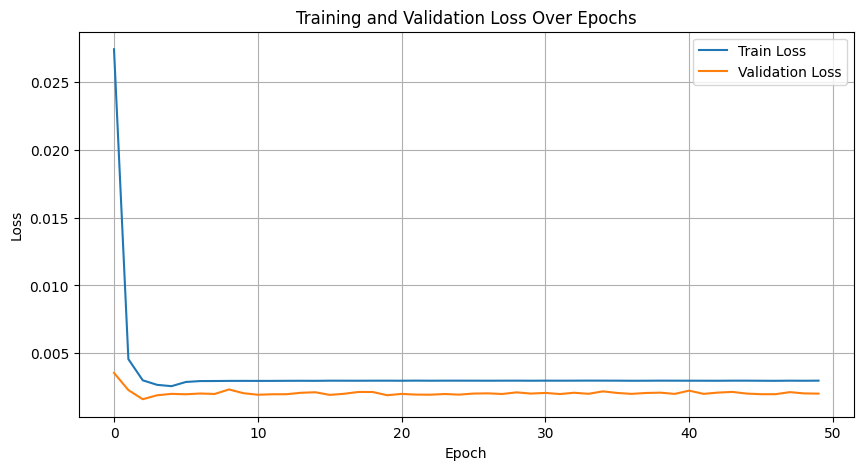

In [138]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_dnn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [139]:
model_path = "soc_dnn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [140]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [141]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.001252
Test MAE: 0.023540
Test StdDev: 0.034872


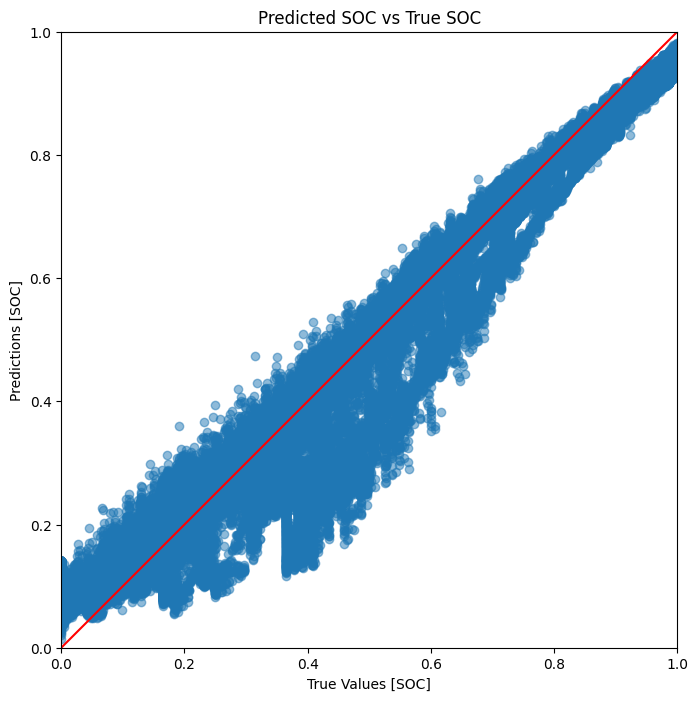

In [142]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

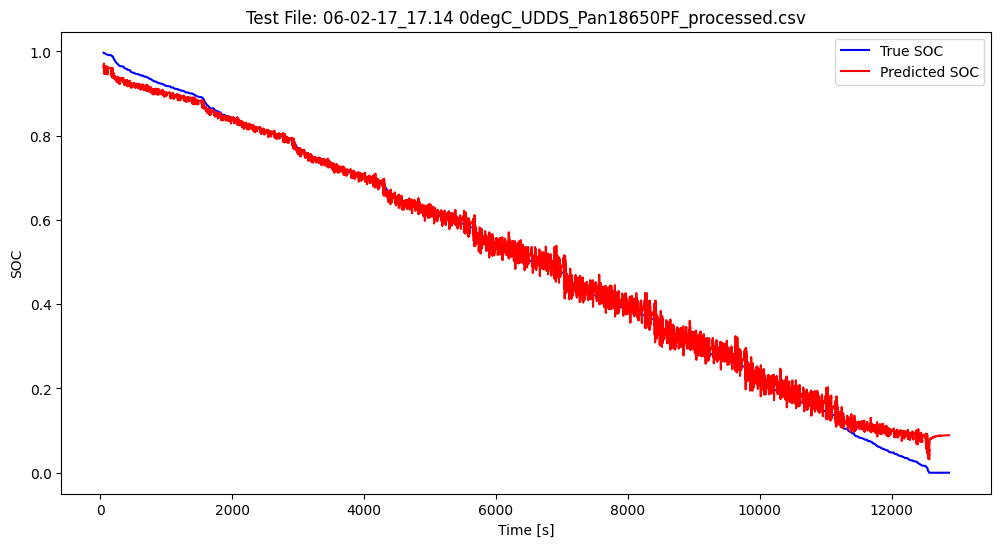

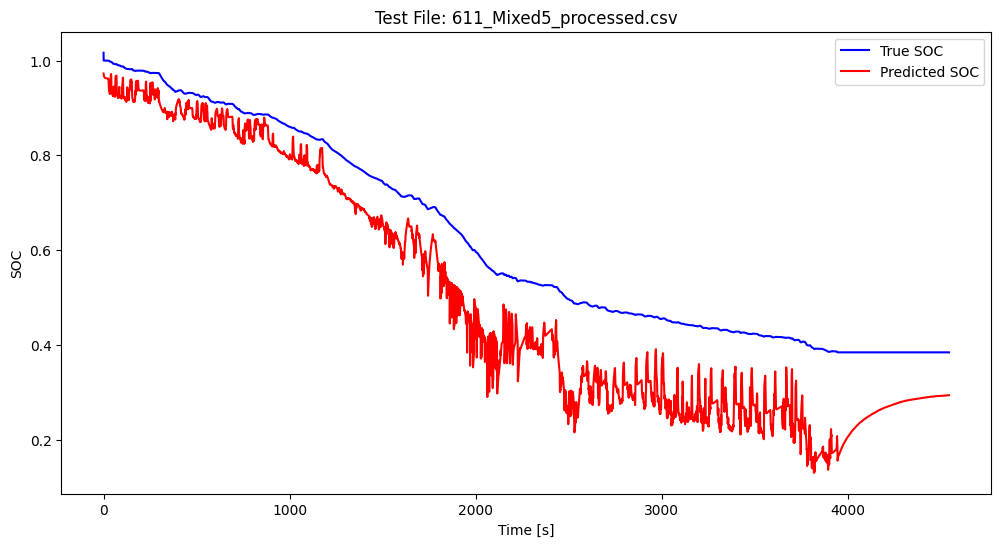

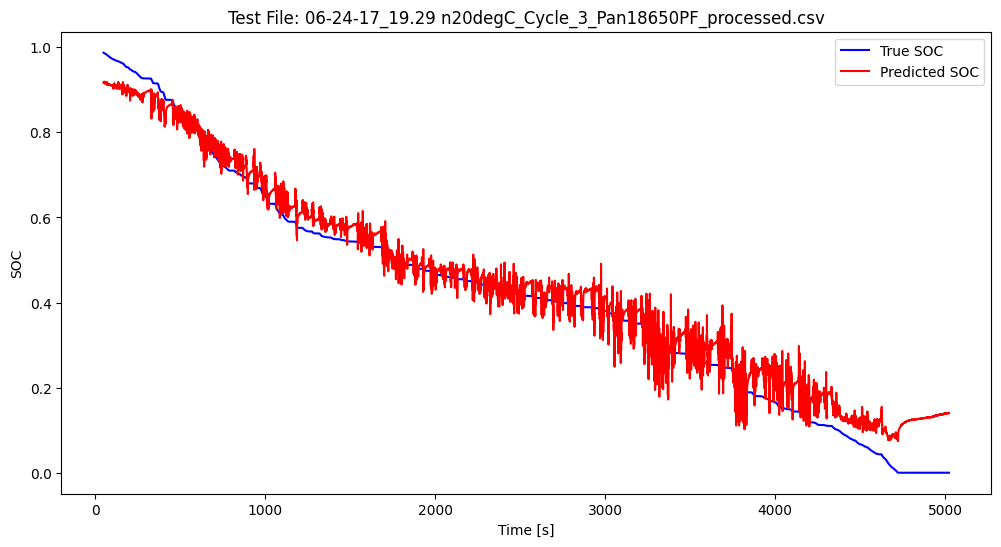

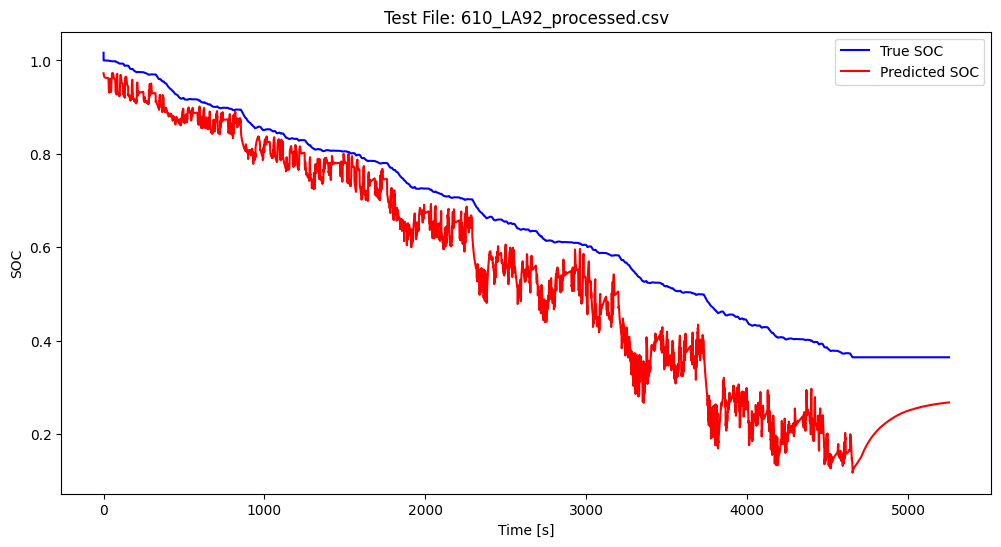

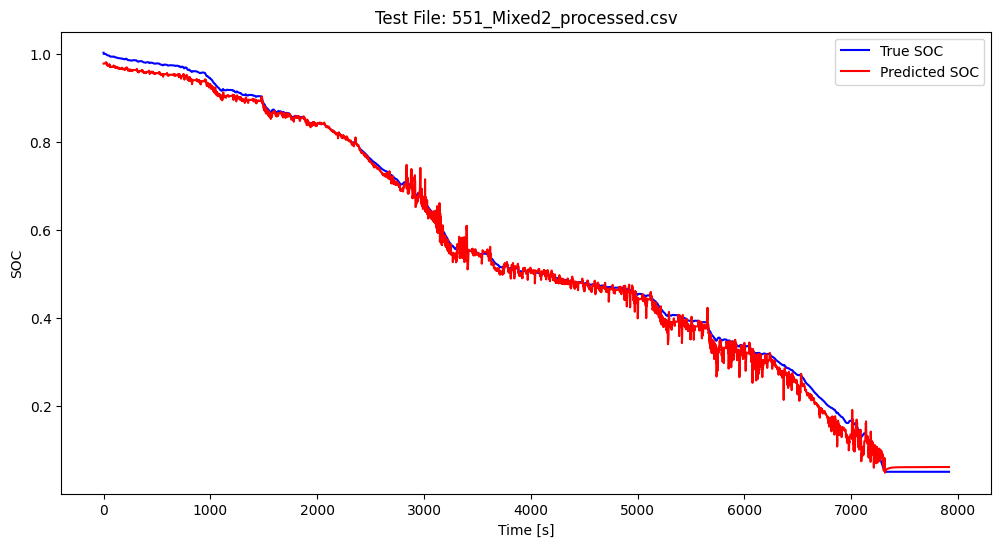

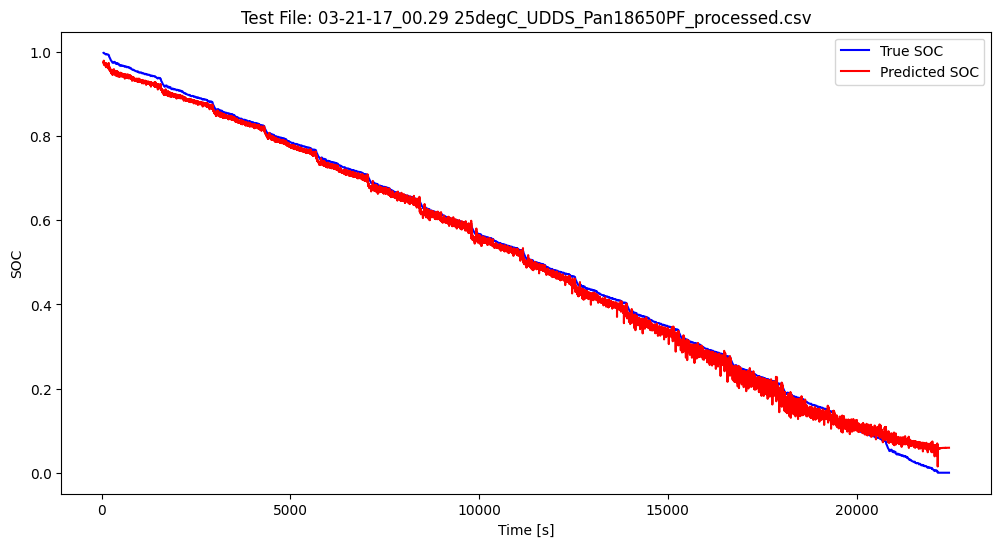

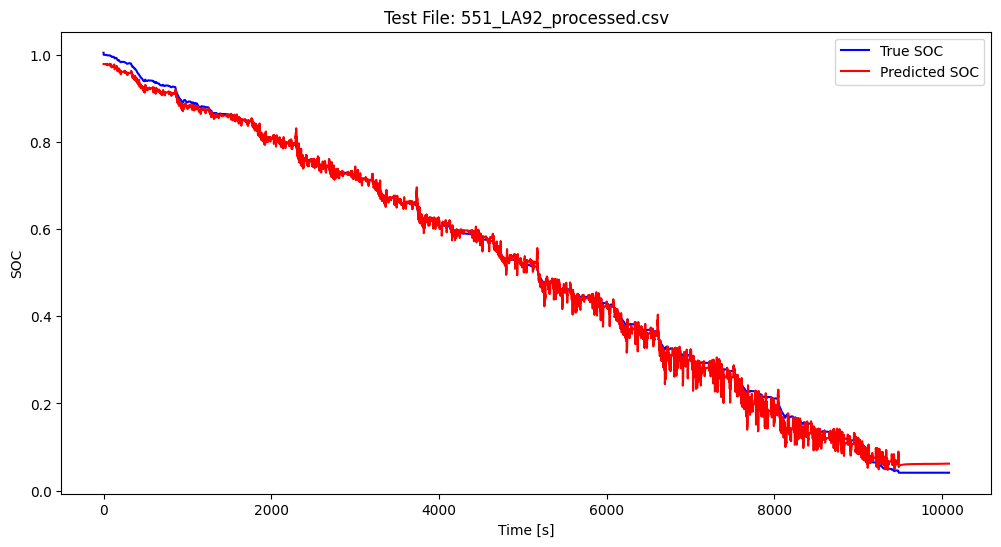

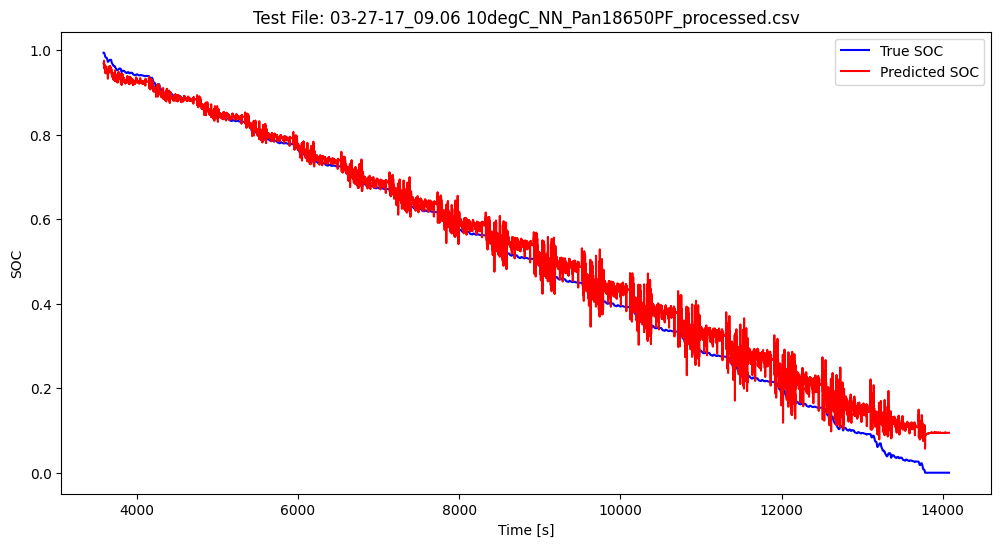

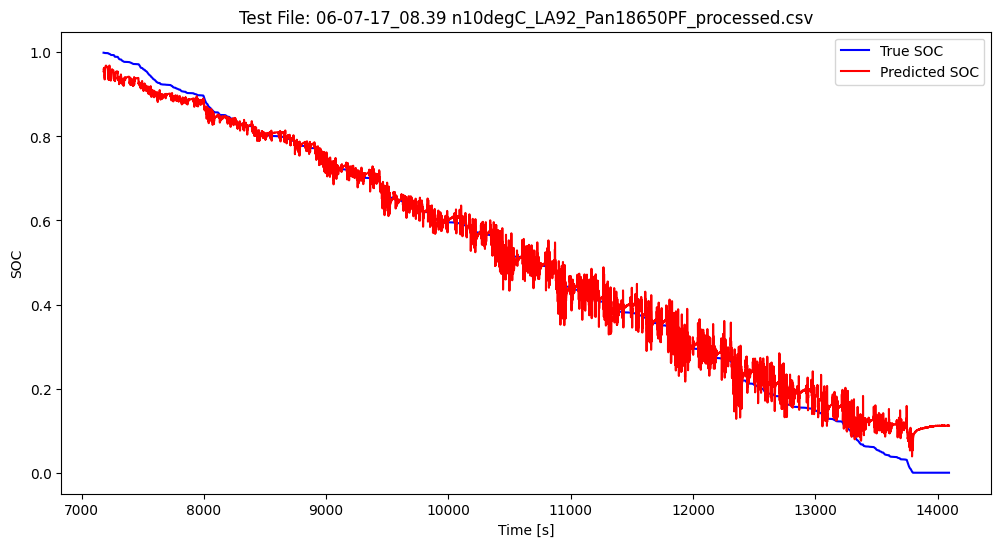

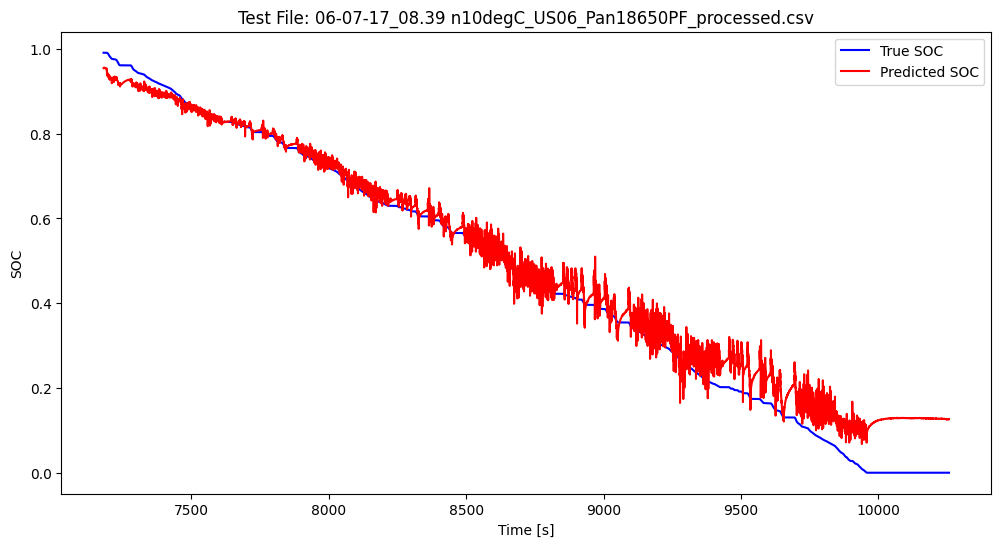

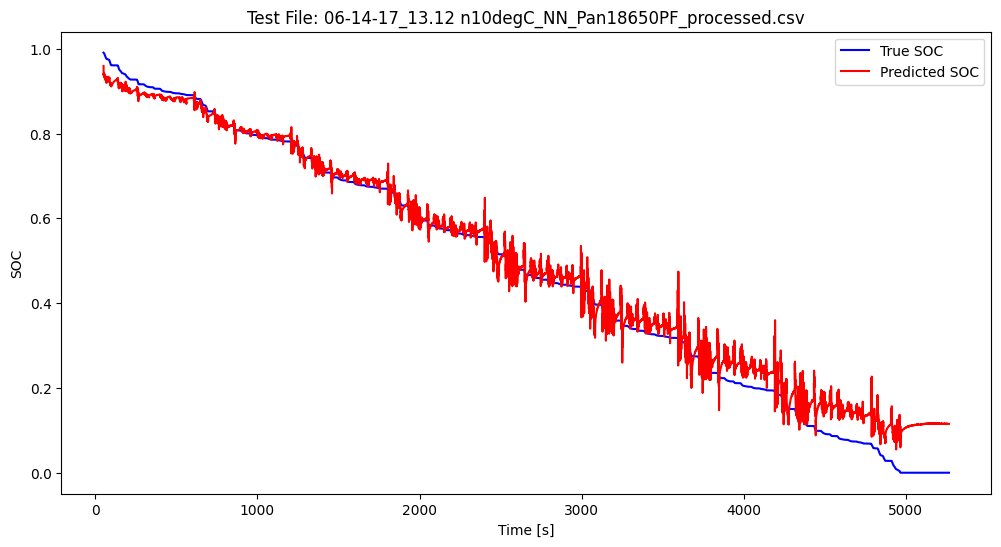

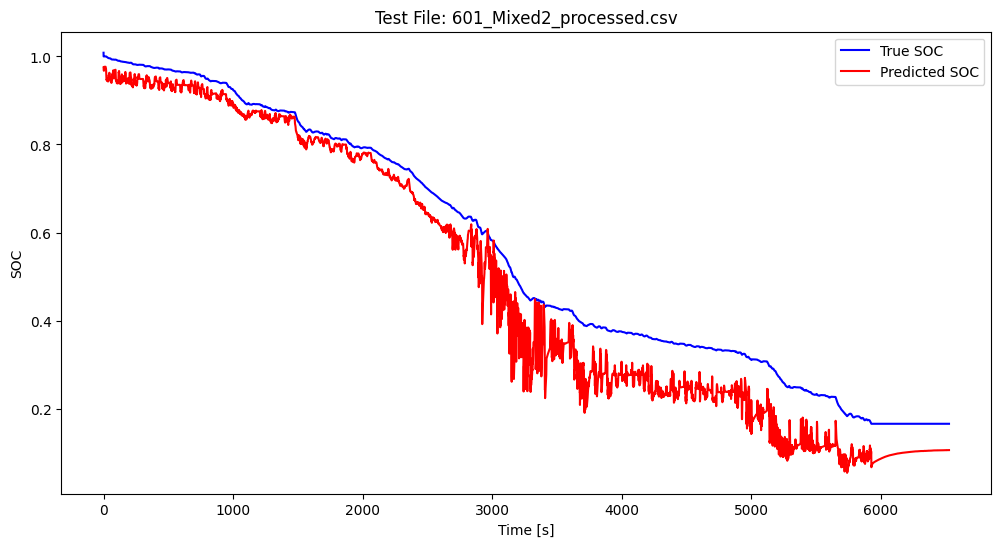

In [143]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)